# 개요

### 1. 전처리  
    아래 방법론을 순차적으로 진행하였는데, 각각의 전처리를 적용할 때마다 정확도가 소폭 상승했음  
    
    a. 뉴스 제목에서 관용적으로 사용되는 한자, 특수문자를 한국어로 치환  
    b. a에 해당하지 않는 한자를 발음 한글로 치환(라이브러리 hanja 사용)  
    c. spellcheck를 통해 띄어쓰기와 문장 교정  

### 2. train_data 레이블 조정  
    최초 추론한 결과에서 잘못 예측한 데이터를 살펴보면 오히려 추론한 class 값이 더 적절해 보인다고 느껴지는 것들이 많았다.
    따라서 추론한 확률값이 기준보다 클 경우에 레이블 값을 바뀌게 하였다. 0.85~ 0.9 사이에서 public score의 개선이 있었다.
    이 작업에 대한 코드는 가장 하단에 배치할 예정

### 3. PLM 미세조정
    여러 모델으로 test했지만, KLUE/roberta-large가 가장 성능이 좋았다.

# 전처리

In [1]:
import numpy as np
import pandas as pd
import os
import re
import hanja
import tqdm
from hanspell import spell_checker

### a. 관용적 특수문자 치환

In [2]:
def replaceChar(data, isTopic=True):
    
    switchar= []
    
    chars = open("./preprocessing/replace_words.txt", encoding='utf-8')
    
    for char in chars:
        switchar.append(char.strip().split("\t"))
        
    if isTopic == True:
        switched_data = pd.DataFrame(columns=["index", "title", "topic_idx"])
    else:
        switched_data = pd.DataFrame(columns=["index", "title"])
        
    for i in tqdm.tqdm(range(len(data))):
        title = data.iloc[i]['title']
        for j in switchar:
            title = re.sub(j[0], j[1]+' ', title)
        title = hanja.translate(' '.join(hanja.split_hanja(title)), 'substitution')
        title = re.sub("[^가-힣0-9a-zA-Z%]",' ', title)
        
        if isTopic == True:
            switched_data = switched_data.append(pd.DataFrame(data=[[i, title, data.iloc[i]["topic_idx"]]], columns=['index', 'title', 'topic_idx']))
        else:
            switched_data = switched_data.append(pd.DataFrame(data=[[i, title]], columns=['index', 'title']))
    
    return switched_data

In [4]:
train_data = pd.read_csv('./data/train_data.csv')
test_data = pd.read_csv('./data/test_data.csv')

replaced_train_data = replaceChar(train_data)
replaced_test_data = replaceChar(test_data, False)

replaced_train_data.to_csv('./data/train_data.rep.csv')
replaced_train_data.to_csv('./data/test_data.rep.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 9131/9131 [00:09<00:00, 984.81it/s]


### b. 한자 -> 한글

### c. spellcheck

In [ ]:
def spellcheck(sents):
    
    spaced_data = []
    
    for sent in tqdm.tqdm(sents):
        
        spelled_sent = spell_checker.check(sent)
        spaced_data.append(spelled_sent.checked)
        
    return spaced_data

In [1]:
# handleing data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

from sklearn import metrics

import time
import datetime
import tqdm
import os
import re

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 3090


In [3]:
#read data
df = pd.read_csv("./data/train_data.naver.rep.spac.csv")
sentences = df.title.values
labels = df.topic_idx.values
print('Number of sentences: {:,}'.format(df.shape[0]))

Number of sentences: 45,654


# 데이터 분포 살펴보기

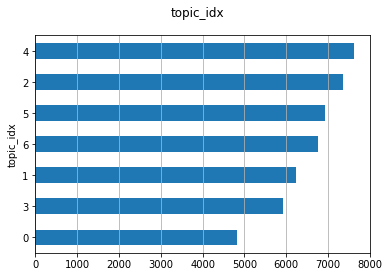

In [4]:
# 레이블 분포
fig, ax = plt.subplots()
fig.suptitle("topic_idx", fontsize=12)
df["topic_idx"].reset_index().groupby("topic_idx").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

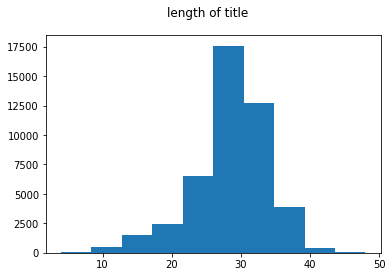

In [5]:
# 문장 길이 분포
train = []
for i in sentences:
    train.append(len(i))
fig, ax = plt.subplots()
fig.suptitle("length of title", fontsize=12)
plt.hist(train)
plt.show()

# Tokenize

In [6]:
tokenizer = BertTokenizer.from_pretrained('klue/roberta-large')

In [7]:
class RobertaTokenize:
    
    def __init__(self, sents, tokenizer):
        self.sents = sents
        self.tokenizer = tokenizer
        
    
    def getLength(self):
        max_len = 0

        for sent in self.sents:
            input_ids = self.tokenizer.encode(sent, add_special_tokens=True) #스패셜토큰 추가하여 encoding
            max_len = max(max_len, len(input_ids)) # max_len설정
        
        return max_len
    
    def encodingDict(self):
        input_ids = []
        attention_masks = []
        max_len = self.getLength()

        for sent in self.sents:

            encoded_dict = self.tokenizer.encode_plus(
                                sent,
                                add_special_tokens = True,
                                max_length = max_len,
                                pad_to_max_length = True,
                                return_attention_mask = True,
                                return_tensors = 'pt',
                           )


            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        
        return input_ids, attention_masks
    

In [8]:
tokenization = RobertaTokenize(sentences, tokenizer)
input_ids, attention_masks = tokenization.encodingDict()
labels = torch.tensor(labels)
dataset = TensorDataset(input_ids, attention_masks, labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

38,805 training samples
6,849 validation samples


# Model: Klue-roberta-large

In [10]:
#hyper params

batch_size = 256
epochs = 10
lr = 5e-5


In [11]:
model = RobertaForSequenceClassification.from_pretrained(
    "klue/roberta-large",
    num_labels = 7,
    output_attentions = False, 
    output_hidden_states = False,
    return_dict=False)

model.cuda()

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(512, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [12]:
train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = RandomSampler(val_dataset), 
            batch_size = batch_size 
        )

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = lr, 
                  eps = 1e-8 )

In [14]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
def save_checkpoint(state, is_best):
        if is_best:
            path = './weights/checkpoint.{:.5f}.pth.tar'.format(state['minimum_loss'])
            torch.save(state, path)  

In [17]:
def training(model, epochs):
    
    training_stats = []
    minimum_loss = 1.
    total_t0 = time.time()
    
    for epoch_i in range(0, epochs):

        t0 = time.time() # Measure how long the training epoch takes.
        total_train_loss = 0  # Reset the total loss for this epoch.

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)

            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)            
        

        print(" [{}/{}] training loss: {:.5f}".format(epoch_i+1, epochs, avg_train_loss))


        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        t0 = format_time(time.time() - t0)
        print("        Validation ==> Acc: {:.5f}, loss: {:.5f}".format(avg_val_accuracy, avg_val_loss))
        print("        time : {}".format(t0))
        
        is_best = bool(avg_val_loss < minimum_loss)
        
        
        if is_best:
            save_checkpoint({
                    'epoch': epoch_i ,
                    'state_dict': model.state_dict(),
                    'minimum_loss': avg_val_loss
                }, is_best)
            
            checkpoint = sorted(os.listdir('./weights/'))[1]
            minimum_loss=float(re.sub('[a-z]','',checkpoint).strip('.'))
            print("    **  Save model: {}".format(minimum_loss))
            
            
            
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
            }
        )

    print("Training complete!")
    return model, training_stats

In [22]:
model, training_stats = training(model, epochs)

 [1/10] training loss: 0.17279
        Validation ==> Acc: 0.87922, loss: 0.40334
        time : 0:01:33
  **    Save model: 0.32689
 [2/10] training loss: 0.10889
        Validation ==> Acc: 0.86809, loss: 0.48563
        time : 0:01:33
 [3/10] training loss: 0.06999
        Validation ==> Acc: 0.87454, loss: 0.54885
        time : 0:01:33
 [4/10] training loss: 0.04165
        Validation ==> Acc: 0.87368, loss: 0.61640
        time : 0:01:33
 [5/10] training loss: 0.02672
        Validation ==> Acc: 0.87483, loss: 0.68002
        time : 0:01:33
 [6/10] training loss: 0.01710
        Validation ==> Acc: 0.87546, loss: 0.71017
        time : 0:01:33
 [7/10] training loss: 0.00811
        Validation ==> Acc: 0.87344, loss: 0.75107
        time : 0:01:33
 [8/10] training loss: 0.00422
        Validation ==> Acc: 0.87657, loss: 0.76954
        time : 0:01:35
 [9/10] training loss: 0.00387
        Validation ==> Acc: 0.87676, loss: 0.76835
        time : 0:01:33
 [10/10] training loss: 0.0

# visualization for training metrics

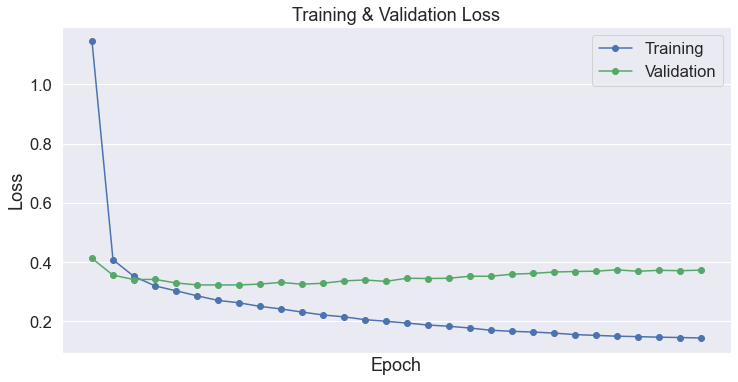

In [32]:
df_stats = pd.DataFrame(data=training_stats)
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(epochs,10)))

plt.show()

# Submission

In [25]:
test_df = pd.read_csv("./data/test_data.rep.spac.csv")
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

test_sentences = test_df.title.values

Number of test sentences: 9,131



In [26]:
testToken = RobertaTokenize(test_sentences)
test_input_ids, test_attention_masks = testToken.encodingDict()

In [27]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size)

In [39]:
path = './weights/checkpoint.0.89653.pht.tar'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [28]:
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    
    predictions +=  list(np.argmax(outputs[0].detach().cpu().numpy(), 1))


print('DONE.')

Predicting labels for 9,131 test sentences...
DONE.


In [29]:
sub = pd.read_csv('./data/sample_submission.csv', index_col='index')
sub['topic_idx'] = predictions

In [30]:
sub.to_csv('./result/0802-klue-prepro_7.csv')

In [5]:
import os

In [9]:
os.path.exists('./weights')

True

In [10]:
os.mkdir('./sample')